# Training an FNO to approximate a dynamical system

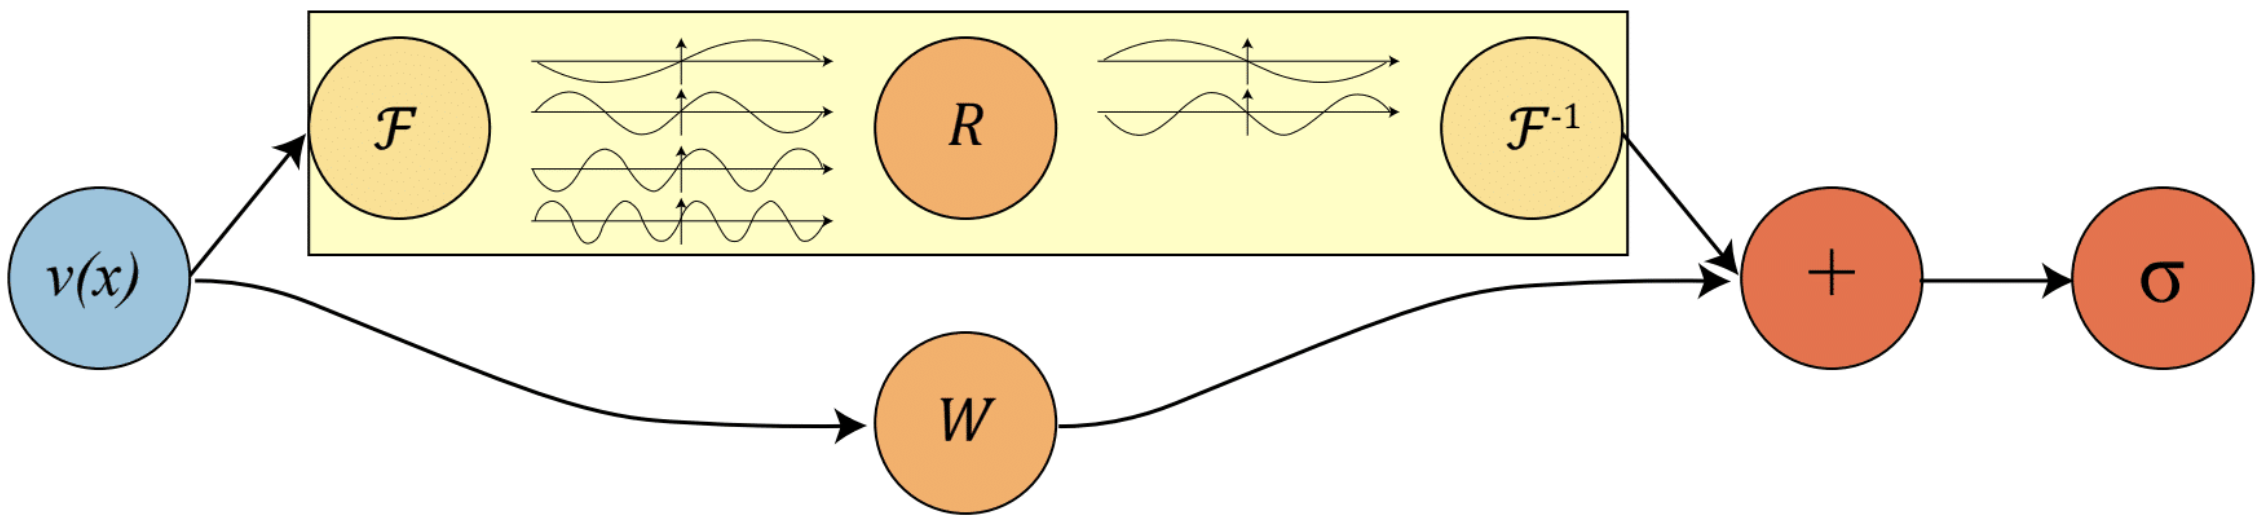

The Fourier layer just consists of three steps:

1. Fourier transform (using FFT)

2. Linear transform on the lower Fourier modes

3. Inverse Fourier transform

In [3]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt


## Define 1D Fourier layer

In [4]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))
        self.conv_layer = nn.Conv1d(in_channels, out_channels, 1)
        self.activation = nn.Tanh()

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


## Build 1D FNO (one to one mapping)

In [5]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        4 Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(1, self.width)  # input channel is 2: (u0(x), x) --> GRID IS INCLUDED!

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        x = x.permute(0, 2, 1)

        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x


In [6]:
torch.manual_seed(0)
np.random.seed(0)

In [7]:
# Load the data
data_train_128 = torch.from_numpy(np.load("Data/data_train_128.npy")).type(torch.float32)
data_test_128 = torch.from_numpy(np.load("Data/data_test_128.npy")).type(torch.float32)
data_val_128 = torch.from_numpy(np.load("Data/data_val_128.npy")).type(torch.float32)

print(data_train_128.shape)
print(data_test_128.shape)
print(data_val_128.shape)

batch_size = 32

training_set = DataLoader(TensorDataset(data_train_128[:, 0, :], data_train_128[:, 4, :]), batch_size=batch_size, shuffle=True)
validation_set = DataLoader(TensorDataset(data_val_128[:, 0, :], data_val_128[:, 4, :]), batch_size=batch_size, shuffle=False)
testing_set = DataLoader(TensorDataset(data_test_128[:, 0, :], data_test_128[:, 4, :]), batch_size=batch_size, shuffle=False)

torch.Size([1024, 5, 128])
torch.Size([128, 5, 128])
torch.Size([32, 5, 128])


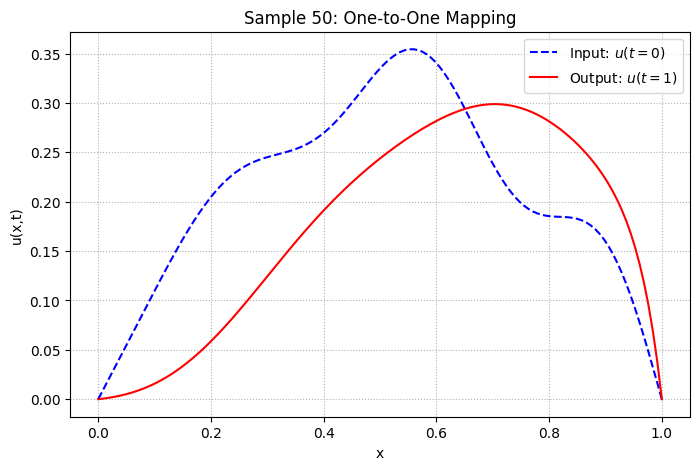

In [8]:
id_sample = 50
num_spatial_points = data_train_128.shape[2]
x = np.linspace(0, 1, num_spatial_points)

u_input  = data_train_128[id_sample, 0, :]
u_output = data_train_128[id_sample, 4, :]

plt.figure(figsize=(8, 5))
plt.plot(x, u_input, label=r"Input: $u(t=0)$", color='blue', linestyle='--')
plt.plot(x, u_output, label=r"Output: $u(t=1)$", color='red')

plt.grid(True, ls=":")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title(f"Sample {id_sample}: One-to-One Mapping")
plt.show()

In [9]:
learning_rate = 0.001
epochs = 250
step_size = 50
gamma = 0.5

In [11]:
modes = 16
width = 128
fno = FNO1d(modes, width) # model


## Training

In [12]:
def calculate_relative_l2(pred, true):
    diff_norm = torch.norm(pred - true, p=2, dim=1)

    true_norm = torch.norm(true, p=2, dim=1)

    loss = torch.mean(diff_norm / true_norm) # = 1/128 * sum

    return loss.item()

In [13]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = nn.MSELoss()
freq_print = 1

train_loss_history = []
test_loss_history = []

for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        input_batch = input_batch.unsqueeze(-1)
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(validation_set):
            input_batch = input_batch.unsqueeze(-1)
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = calculate_relative_l2(output_pred_batch, output_batch)
            test_relative_l2 += loss_f
        test_relative_l2 /= len(testing_set)

    test_loss_history.append(test_relative_l2)
    train_loss_history.append(train_mse)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)



######### Epoch: 0  ######### Train Loss: 0.06289679883047938  ######### Relative L2 Test Norm: 0.11224135756492615
######### Epoch: 1  ######### Train Loss: 0.015980021795257926  ######### Relative L2 Test Norm: 0.09677666425704956
######### Epoch: 2  ######### Train Loss: 0.007182907298556529  ######### Relative L2 Test Norm: 0.08544155210256577
######### Epoch: 3  ######### Train Loss: 0.0052677327184937894  ######### Relative L2 Test Norm: 0.05089263617992401
######### Epoch: 4  ######### Train Loss: 0.00362573847087333  ######### Relative L2 Test Norm: 0.04707872495055199
######### Epoch: 5  ######### Train Loss: 0.0032481260059284978  ######### Relative L2 Test Norm: 0.042486898601055145
######### Epoch: 6  ######### Train Loss: 0.0026396967259643134  ######### Relative L2 Test Norm: 0.05897087603807449
######### Epoch: 7  ######### Train Loss: 0.002867360439267941  ######### Relative L2 Test Norm: 0.04793325066566467
######### Epoch: 8  ######### Train Loss: 0.002110888992319815

In [15]:
save_path = os.path.join("model_storage", f"one_to_one_model.pt")
torch.save({
    "model_state_dict": fno.state_dict(),
    "test_loss_history": test_loss_history,
    "train_loss_history": train_loss_history,
    "modes": modes,
    "width": width,
    "optimizer_state_dict": optimizer.state_dict(),
}, save_path)

## Final average L2 error for task 1:
Relative L2 Test Norm: 0.022324780002236366

### Plotting test and train error

Loaded model from model_storage\one_to_one_model.pt
Training epochs recorded: 250


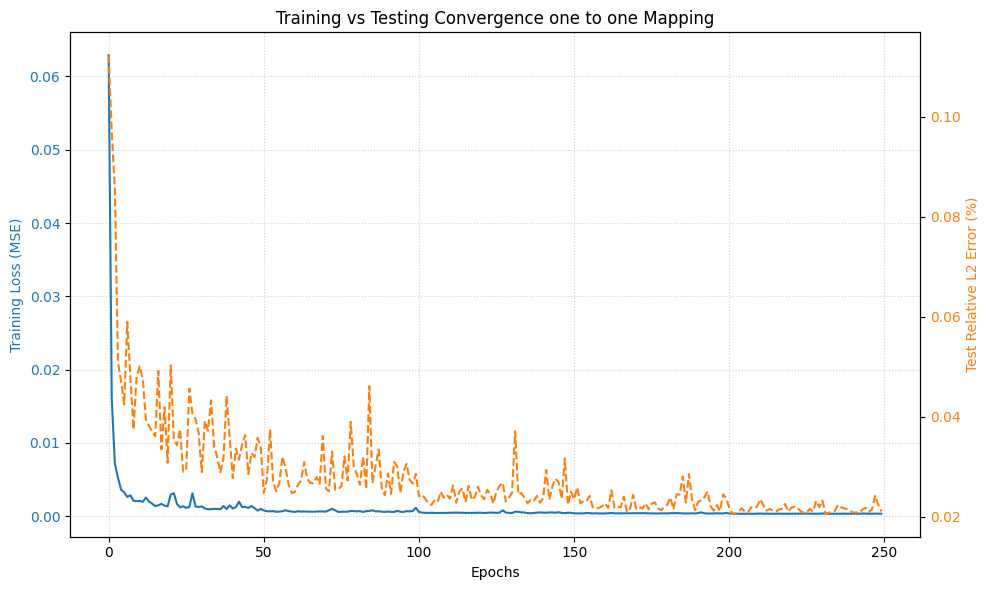

In [16]:
load_path = os.path.join("model_storage", f"one_to_one_model.pt")

checkpoint = torch.load(load_path)
train_history = checkpoint["train_loss_history"]
test_history = checkpoint["test_loss_history"]
print(f"Loaded model from {load_path}")
print(f"Training epochs recorded: {len(train_history)}")

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss (MSE)', color=color)
ax1.plot(train_history, color=color, label='Train MSE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle=':', alpha=0.6)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Test Relative L2 Error (%)', color=color)
ax2.plot(test_history, color=color, linestyle='--', label='Test Rel L2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"Training vs Testing Convergence one to one Mapping")
fig.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

## Plot for one example

Sample 32 Relative L2 error: 4.23%


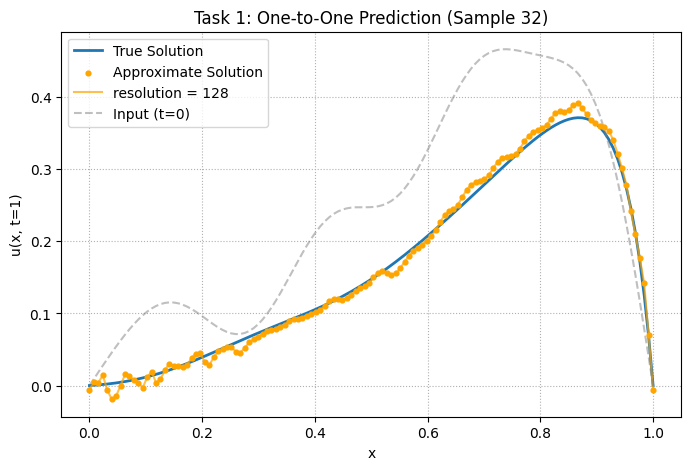

In [24]:
idx_data = 32

raw_input = data_test_128[idx_data, 0, :]
raw_target = data_test_128[idx_data, 4, :]

input_tensor = raw_input.unsqueeze(0).unsqueeze(-1)

fno.eval()
with torch.no_grad():
    pred_tensor = fno(input_tensor).squeeze()

res = raw_target.shape[0]
x_grid = np.linspace(0, 1, res)

plt.figure(figsize=(8, 5))
plt.grid(True, which="both", ls=":")

plt.plot(x_grid, raw_target.numpy(), label="True Solution", c="C0", lw=2)

plt.scatter(x_grid, pred_tensor.numpy(), label="Approximate Solution", s=12, c="orange", zorder=3)
plt.plot(x_grid, pred_tensor.numpy(), color="orange", label=f"resolution = {res}", alpha=0.7)

plt.plot(x_grid, raw_input.numpy(), label="Input (t=0)", c="gray", ls="--", alpha=0.5)

p = 2
diff = torch.norm(raw_target - pred_tensor, p=p)
true_norm = torch.norm(raw_target, p=p)
err = (diff / true_norm) * 100

print(f"Sample {idx_data} Relative L2 error: {err.item():.2f}%")

plt.legend()
plt.xlabel("x")
plt.ylabel("u(x, t=1)")
plt.title(f"Task 1: One-to-One Prediction (Sample {idx_data})")
plt.show()

# Task 2 Testing on Different Resolutions

In [18]:
# Load the data for resolutions {32, 64, 96, 128}
data_test_128 = torch.from_numpy(np.load("Data/data_test_128.npy")).type(torch.float32)
data_test_96 = torch.from_numpy(np.load("Data/data_test_96.npy")).type(torch.float32)
data_test_64 = torch.from_numpy(np.load("Data/data_test_64.npy")).type(torch.float32)
data_test_32 = torch.from_numpy(np.load("Data/data_test_32.npy")).type(torch.float32)

print(data_test_128.shape)
print(data_test_96.shape)
print(data_test_64.shape)
print(data_test_32.shape)

batch_size = 32

testing_set_128 = DataLoader(TensorDataset(data_test_128[:, 0, :], data_test_128[:, 4, :]), batch_size=batch_size, shuffle=False)
testing_set_96 = DataLoader(TensorDataset(data_test_96[:, 0, :], data_test_96[:, 4, :]), batch_size=batch_size, shuffle=False)
testing_set_64 = DataLoader(TensorDataset(data_test_64[:, 0, :], data_test_64[:, 4, :]), batch_size=batch_size, shuffle=False)
testing_set_32 = DataLoader(TensorDataset(data_test_32[:, 0, :], data_test_32[:, 4, :]), batch_size=batch_size, shuffle=False)

torch.Size([128, 5, 128])
torch.Size([128, 5, 96])
torch.Size([128, 5, 64])
torch.Size([128, 5, 32])


In [22]:
save_path = os.path.join("model_storage", f"one_to_one_model.pt")
checkpoint = torch.load(save_path)

modes = checkpoint["modes"]
width = checkpoint["width"]

fno_loaded = FNO1d(modes, width)
fno_loaded.load_state_dict(checkpoint["model_state_dict"])
fno_loaded.eval()

def evaluate_loader(loader, model, label):
    total_rel_err = 0.0
    model.eval()

    with torch.no_grad():
        for input_batch, output_batch in loader:
            input_batch = input_batch.unsqueeze(-1)

            output_pred = model(input_batch).squeeze(2)

            diff_norm = torch.norm(output_pred - output_batch, p=2, dim=1)
            true_norm = torch.norm(output_batch, p=2, dim=1)

            total_rel_err += torch.sum(diff_norm / true_norm).item()

    avg_err = (total_rel_err / len(loader.dataset)) * 100
    print(f"Resolution {label}: Average Relative L2 Error = {avg_err:.4f}%")
    return avg_err


# Resolution 128
err_128 = evaluate_loader(testing_set_128, fno_loaded, "128")

# Resolution 96
err_96 = evaluate_loader(testing_set_96, fno_loaded, "96")

# Resolution 64
err_64 = evaluate_loader(testing_set_64, fno_loaded, "64")

# Resolution 32
err_32 = evaluate_loader(testing_set_32, fno_loaded, "32")

Resolution 128: Average Relative L2 Error = 5.9122%
Resolution 96: Average Relative L2 Error = 6.2231%
Resolution 64: Average Relative L2 Error = 6.6162%
Resolution 32: Average Relative L2 Error = 8.8245%
